# PYCE Loans Model

### Machine Learning Model for calculating the probability of loan default and estimating interest rates to maximize profits

### Methods used and compared: Linear Regression, Logistic Regression, Random Forest

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
import time
import warnings
warnings.filterwarnings("ignore")

### Past Loans
- 100,000 loans
- No null values or outliers
- 19,632 defaults: 19.6% default rate

In [2]:
df_total = pd.read_csv('PastLoans.csv').drop('id', axis = 1)
df_total

,sex,employment,marital,income,social1,social2,social3,default
0,1,unemployed,0,5458,0.028116,0.983725,0.732502,0
1,1,employed,1,26108,0.638239,0.592502,0.615449,0
2,1,employed,1,11810,0.240542,0.630370,0.174645,0
3,1,unemployed,1,5375,0.648089,0.000000,0.216376,0
4,0,retired,1,3459,0.360834,0.000000,0.346708,1
...,...,...,...,...,...,...,...,...
99995,1,student,0,3442,0.548980,0.057879,0.064186,0
99996,1,employed,0,22947,0.000000,0.779408,0.726523,0
99997,1,employed,0,29567,0.802285,0.733289,0.589167,0
99998,1,employed,1,66772,0.231345,0.675198,0.655388,0


In [3]:
df_total.describe()

,sex,marital,income,social1,social2,social3,default
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.725190,0.610080,19682.353060,0.418179,0.415494,0.414410,0.196320
std,0.446421,0.487734,50489.814607,0.324487,0.325033,0.324663,0.397215
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,5820.000000,0.066323,0.061329,0.060052,0.000000
50%,1.000000,1.000000,9810.000000,0.453770,0.442771,0.440763,0.000000
75%,1.000000,1.000000,18177.250000,0.694809,0.693125,0.691053,0.000000
max,1.000000,1.000000,1000000.000000,0.999994,0.999982,0.999980,1.000000


In [4]:
proportion = df_total.default.value_counts()
print("Default rate for past loans: {:.2f}%".format(proportion.loc[1]/proportion.sum()*100))
proportion

Default rate for past loans: 19.63%


0    80368
1    19632
Name: default, dtype: int64

## Functions

#### - Data cleaning and preprocessing
#### - Train & test models in past loans using Kfold
#### - Analyze data and compare models

In [5]:
# Prepare dataframe and identify model features relevant to loan defaults
def preprocess(df):
    tot = df.copy()
    
    enc = OneHotEncoder(categories='auto') # Create dummy variables
    features = enc.fit_transform(tot[['employment']]).toarray() # Transform categorical into numerical
    names = np.concatenate(enc.categories_) # Transform above variables into column names
    
    l_drop = ['employment','default', 'social1','social3'] # Focus on social2 profiles
    X = pd.DataFrame(features, columns=names) # Create dataframe with dummy variables
    
    # Substitute categorical variable in original dataframe
    X = pd.concat([tot, X],axis=1) 
    X = X.drop(l_drop,axis=1)
    y = tot['default']
    return (X,y)


# Print the default rate for each group
def print_default_rates(model, bins):
    df = model.sort_values(by= 'probability').reset_index().drop('index', axis = 1)
    #df['decile'] = pd.qcut(df['probability'], bins, labels = False)
    num = df.shape[0]//bins #Samples per group
    for i in range(bins):
        x = df.iloc[num*i : num*(i+1)].default.value_counts()
        if x.shape[0] == 2:
            print('Percentile {}: {:.2f}%'.format(i+1, x.loc[1]/x.sum()*100))
        else:
            print('Percentile {}: 0.00% <--'.format(i+1))
    return


# Run model and complile results
def runModel(df,regr):
    X, y = preprocess(df)
    
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    cont = 0
    menor = 10000000
    for train_index, test_index in kf.split(X):
        
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        
        regr.fit(X_train, y_train)
        pred = regr.predict(X_test)
        
        
        aux = X_test.copy()
        aux['default'] = y_test
        aux['probability'] = pred
        
        if cont == 0:
            df_result = aux
        else:
            df_result = pd.concat([df_result, aux])
        cont += 1
    return df_result

## Model 1: Random Forest

#### Arbitrary parameters: they can be fine-tuned later (GridSearchCV)

In [16]:
# Stratifying past loans into quartiles, based on default probability

start_time = time.time()

regr = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=10,
                      n_estimators=500, random_state=1)

print("********* Random Forest *********")
rf_model = runModel(df_total,regr)
print_default_rates(rf_model, 10)
print("--- {:.2f} seconds ---".format(time.time() - start_time))

********* Random Forest *********
Percentile 1: 2.72%
Percentile 2: 7.52%
Percentile 3: 10.56%
Percentile 4: 13.90%
Percentile 5: 17.48%
Percentile 6: 20.68%
Percentile 7: 24.16%
Percentile 8: 28.10%
Percentile 9: 31.56%
Percentile 10: 39.64%
--- 247.42 seconds ---


In [ ]:
plt.hist(rf_model[rf_model['default'] == 0].probability)
plt.title('Probability distribution - no default')
plt.show()

plt.hist(rf_model[rf_model['default'] == 1].probability)
plt.title('Probability distribution - default')
plt.show()

## Model 2: Linear Regression

In [15]:
start_time = time.time()

regr = LinearRegression()

print("********* Random Forest *********")
lr_model = runModel(df_total,regr)
print_default_rates(lr_model, 10)
print("--- {:.2f} seconds ---".format(time.time() - start_time))

********* Random Forest *********
Percentile 1: 5.56%
Percentile 2: 11.18%
Percentile 3: 15.32%
Percentile 4: 17.65%
Percentile 5: 18.73%
Percentile 6: 20.52%
Percentile 7: 20.94%
Percentile 8: 25.19%
Percentile 9: 26.18%
Percentile 10: 35.05%
--- 0.44 seconds ---


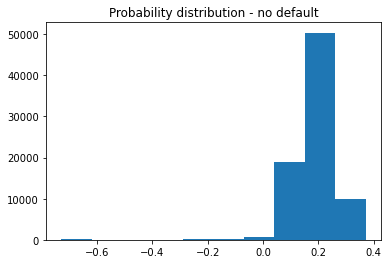

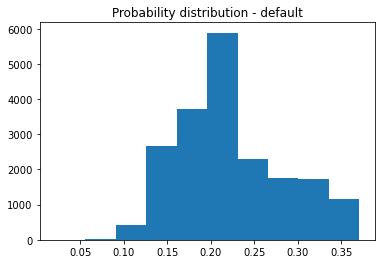

In [16]:
plt.hist(lr_model[lr_model['default'] == 0].probability)
plt.title('Probability distribution - no default')
plt.show()

plt.hist(lr_model[lr_model['default'] == 1].probability)
plt.title('Probability distribution - default')
plt.show()

In [34]:
X, y = preprocess(df_total)
cols = list(X.columns)
importance = {}
intercepts = []
for el in cols:
    importance[el] = []
    

for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    regr.fit(X_train, y_train)
    intercepts.append(regr.intercept_)
    for i in range(len(cols)):
        importance[cols[i]].append(regr.coef_[i])
    
print('Features: ', ', '.join(cols))
print(np.mean(intercepts), '+')
for el in cols:
    print('{:.2e} * {} +'.format(np.mean(importance[el]), el))

Features:  sex, marital, income, social2, employed, retired, student, unemployed
0.2961012563869404 +
-7.81e-03 * sex +
-1.64e-02 * marital +
-8.46e-07 * income +
-1.14e-01 * social2 +
-4.31e-02 * employed +
-6.88e-02 * retired +
3.77e-02 * student +
7.41e-02 * unemployed +


## Model 3: Logistic Regression

In [36]:
start_time = time.time()

regr = LogisticRegression()

print("********* Logistic Regression *********")
log_model = runModel(df_total,regr)
print("--- {:.2f} seconds ---".format(time.time() - start_time))

********* Logistic Regression *********
--- 1.06 seconds ---


It makes sense that our model always predicts 0 because the dataset is severly imbalanced in favor of the negative class (no default)

https://stats.stackexchange.com/questions/168929/logistic-regression-is-predicting-all-1-and-no-0

In [37]:
log_model

,sex,marital,income,social2,employed,retired,student,unemployed,default,probability
1,1,1,26108,0.592502,1.0,0.0,0.0,0.0,0,0
4,0,1,3459,0.000000,0.0,1.0,0.0,0.0,1,0
6,0,0,6085,0.690899,1.0,0.0,0.0,0.0,1,0
8,0,1,4506,0.823873,1.0,0.0,0.0,0.0,0,0
10,1,1,5768,0.000000,1.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...
99982,1,0,30992,0.573553,1.0,0.0,0.0,0.0,0,0
99989,1,1,18364,0.845136,1.0,0.0,0.0,0.0,0,0
99992,1,1,10165,0.000000,0.0,1.0,0.0,0.0,0,0
99993,1,0,19044,0.604602,0.0,0.0,0.0,1.0,0,0


In [39]:
log_model.probability.value_counts()

0    100000
Name: probability, dtype: int64

# Interest Rate Calculation

### The function is based on 3 main variables:

- Default risk: the probability above which we don't give loans
- Breakeven interest rate calculation: function of the probability of default
- Floot: minimal rate (for applicants with 0% probability of default according to the model

Our initial strategy was to minimize the number of loans and thus the default rate, allowing us to give lower interest rates than our competitors

In [44]:
x = rf_model[rf_model['probability'] <= 0.05]
x['rate'] = x['probability']/(1-x['probability']) + 0.04
x['profit'] = np.where(x['default'] == 0, 10000*x['rate'], -10000)
x

,sex,marital,income,social2,employed,retired,student,unemployed,default,probability,rate,profit
1,1,1,26108,0.592502,1.0,0.0,0.0,0.0,0,0.033768,0.074948,749.478389
12,1,1,15397,0.862322,1.0,0.0,0.0,0.0,0,0.031020,0.072013,720.133422
30,1,1,27316,0.692050,1.0,0.0,0.0,0.0,0,0.033053,0.074183,741.833086
50,0,1,25250,0.856491,1.0,0.0,0.0,0.0,0,0.026714,0.067447,674.469926
53,1,1,74023,0.536551,1.0,0.0,0.0,0.0,0,0.000108,0.040108,401.076374
...,...,...,...,...,...,...,...,...,...,...,...,...
99880,1,0,29429,0.486538,1.0,0.0,0.0,0.0,0,0.018747,0.059105,591.052348
99940,1,1,12923,0.879925,1.0,0.0,0.0,0.0,0,0.029655,0.070561,705.613647
99955,0,0,0,0.995915,0.0,0.0,1.0,0.0,0,0.038084,0.079592,795.919672
99992,1,1,10165,0.000000,0.0,1.0,0.0,0.0,0,0.021855,0.062343,623.430656


In [46]:
x.profit.sum()

316196.32420589996

## Run the model for new applicants

#### pyce_loans.csv: interest rates for new applicants (null if loan is denied)

In [19]:
def preprocess2(df):
    tot = df.copy()
    
    enc = OneHotEncoder(categories='auto') # Create dummy variables
    features = enc.fit_transform(tot[['employment']]).toarray() # Transform categorical into numerical
    names = np.concatenate(enc.categories_) # Transform above variables into column names
    
    l_drop = ['employment'] # Focus on social2 profiles
    X = pd.DataFrame(features, columns=names) # Create dataframe with dummy variables
    
    # Substitute categorical variable in original dataframe
    X = pd.concat([tot, X],axis=1) 
    X = X.drop(l_drop,axis=1)
    return X

In [6]:
start_time = time.time()


regr = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=10,
                      n_estimators=500, random_state=1)
df = pd.read_csv('LoanApplications_Stage1_Lender2.csv').drop('id', axis = 1)

X, y = preprocess(df_total)
regr.fit(X, y)
df['probability'] = regr.predict(preprocess2(df))

print("--- {:.2f} seconds ---".format(time.time() - start_time))
df

--- 73.84 seconds ---


,sex,employment,marital,income,social2,probability
0,1,employed,1,7787,0.521474,0.230177
1,1,retired,1,9286,0.072545,0.148238
2,1,employed,1,25586,0.193502,0.076151
3,1,employed,1,57661,0.904576,0.000365
4,1,retired,0,3943,0.325358,0.317087
...,...,...,...,...,...,...
99995,1,retired,0,22188,0.000000,0.020217
99996,1,student,0,0,0.391565,0.496161
99997,1,employed,1,5615,0.834428,0.177374
99998,1,unemployed,1,16573,0.318897,0.250118


In [7]:
df['rate'] = np.where(df['probability'] < 0.05, df['probability']/(1-df['probability']) + 0.04, None)
df.rate.value_counts(dropna = False)

NaN         79092
0.040000     1107
0.040030       97
0.040141       91
0.042004       73
            ...  
0.078637        1
0.079113        1
0.057483        1
0.085944        1
0.087566        1
Name: rate, Length: 15559, dtype: int64

In [9]:
df.probability.to_csv('probability_stage1.csv')
df.drop('probability', axis = 1).to_csv('pyce_loans.csv')

In [54]:
rf_model['rate'] = np.where(rf_model['probability'] < 0.05, rf_model['probability']/(1-rf_model['probability']) + 0.04, None)
rf_model.to_csv('rf_model.csv')

# Optimizing the parameters

We ran 144 combinations of 7 parameters to choose the best model, based on the root mean squared error metric to assess the accuracy of the models

In [6]:
#RMSE function

def rmse_function(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)

    distance = predict - actual

    square_distance = distance ** 2

    mean_square_distance = square_distance.mean()

    score = np.sqrt(mean_square_distance)

    return score

In [12]:
#Parameters optimization

def runGrid(df, regr, param_grid):
    X, y = preprocess(df)
    
    rmse_score = make_scorer(rmse_function,greater_is_better=False)
    grid_search = GridSearchCV(estimator = regr, param_grid = param_grid,
                               scoring = rmse_score, cv = 5, n_jobs = 1, verbose = 2)

    grid_search.fit(X, y)
    return grid_search

In [13]:
#Roda hiperparâmetros

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10,50, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 10],
    'min_samples_split': [2, 10],
    'n_estimators': [100, 200, 500],
    'random_state':[1]
}
    
rf = RandomForestRegressor()
    
grid = runGrid(df_total, rf, param_grid)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=1; total time=  16.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=1; total time=  18.9s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=1; total time=  15.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=1; total time=  14.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=1; total time=  14.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=1; total time=  29.9s
[CV] END bootstrap=True, 

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=1; total time=  35.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=500, random_state=1; total time= 1.4min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=500, random_state=1; total time= 1.4min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=500, random_state=1; total time= 1.4min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=500, random_state=1; total time= 1.4min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=500, random_state=1; total time= 1.4min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=1; total time=   6.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=1; total time=   6.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=1; total time=  13.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=1; total time=  13.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=1; total time=  13.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=1; total time=  13.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=500, random_state=1; total time= 2.2min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=500, random_state=1; total time= 2.3min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=500, random_state=1; total time= 2.3min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=1; total time=  27.2s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=1; total time=  29.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=1; total time=  27.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=10, 

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=200, random_state=1; total time=  18.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=200, random_state=1; total time=  18.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=200, random_state=1; total time=  18.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=200, random_state=1; total time=  18.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500, random_state=1; total time=  48.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500, random_state=1; total time=  49.8s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=10, min

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100, random_state=1; total time=  29.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100, random_state=1; total time=  32.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100, random_state=1; total time=  34.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100, random_state=1; total time=  28.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100, random_state=1; total time=  29.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=200, random_state=1; total time=  59.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_sample

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200, random_state=1; total time=  25.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200, random_state=1; total time=  24.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500, random_state=1; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500, random_state=1; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500, random_state=1; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500, random_state=1; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_sample

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, random_state=1; total time=  25.6s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, random_state=1; total time=  25.9s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, random_state=1; total time=  25.5s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, random_state=1; total time=  25.4s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, random_state=1; total time=  51.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, random_state=1; total time=  50.4s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=1; total time=  49.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=1; total time=  50.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=1; total time=  49.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=1; total time=  51.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=1; total time=  49.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, random_state=1; total time=   9.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, mi

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=1; total time=  46.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=1; total time= 1.6min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=1; total time= 1.6min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=1; total time= 1.6min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=1; total time= 1.6min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=1; total time= 1.6min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=500, random_state=1; total time= 3.1min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=500, random_state=1; total time= 3.1min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=1; total time=  22.1s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=1; total time=  21.8s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=1; total time=  22.3s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=1; total time=  21.8s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1,

[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=1; total time=  29.4s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=1; total time=  29.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=1; total time=  29.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=500, random_state=1; total time= 1.2min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=500, random_state=1; total time= 1.2min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=500, random_state=1; total time= 1.2min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=1; total time=  38.4s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=1; total time=  43.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=1; total time=  37.5s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=1; total time=  37.3s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=1; total time=  36.9s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=1; total time= 1.2min
[CV] END bootstrap=False, max_depth=None, max_features=aut

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=200, random_state=1; total time=  23.6s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=200, random_state=1; total time=  23.8s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500, random_state=1; total time= 1.0min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500, random_state=1; total time= 1.0min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500, random_state=1; total time=  58.6s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500, random_state=1; total time=  58.7s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min

In [14]:
grid.best_estimator_

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=10,
                      n_estimators=500, random_state=1)

In [17]:
start_time = time.time()

regr = grid.best_estimator_

print("********* Random Forest *********")
rf_model = runModel(df_total,regr)
print_default_rates(rf_model, 10)
print("--- {:.2f} seconds ---".format(time.time() - start_time))

********* Random Forest *********
Percentile 1: 1.73%
Percentile 2: 5.77%
Percentile 3: 8.95%
Percentile 4: 12.13%
Percentile 5: 16.50%
Percentile 6: 21.33%
Percentile 7: 23.94%
Percentile 8: 27.82%
Percentile 9: 33.87%
Percentile 10: 44.28%
--- 136.74 seconds ---


In [20]:
start_time = time.time()

df = pd.read_csv('LoanApplications_Stage1_Lender2.csv').drop('id', axis = 1)

X, y = preprocess(df_total)
regr.fit(X, y)
df['probability'] = regr.predict(preprocess2(df))

print("--- {:.2f} seconds ---".format(time.time() - start_time))
df

--- 53.81 seconds ---


,sex,employment,marital,income,social2,probability
0,1,employed,1,7787,0.521474,0.291848
1,1,retired,1,9286,0.072545,0.175391
2,1,employed,1,25586,0.193502,0.079274
3,1,employed,1,57661,0.904576,0.014177
4,1,retired,0,3943,0.325358,0.239929
...,...,...,...,...,...,...
99995,1,retired,0,22188,0.000000,0.059121
99996,1,student,0,0,0.391565,0.400499
99997,1,employed,1,5615,0.834428,0.238915
99998,1,unemployed,1,16573,0.318897,0.173570


In [25]:
df.probability.to_csv('updated_probs_stage1.csv')

## Calculating the expected default rate (past loans)

In [11]:
rf_model = pd.read_csv('rf_model.csv', index_col=0)
rf_model[rf_model.rate.notnull()][rf_model.default ==1].shape[0]/rf_model[rf_model.rate.notnull()].shape[0]

0.053746842548414255